In [27]:
data = [
        {
            "model": "Qwen-2.5-3B",
            "params": 3,
            "gpu": "RTX 3090",
            "memory_gb": 24,
            "bandwidth_gbs": 936,
            "power_w": 350,
            "energy_per_token_j": 0.8306
        },
        {
            "model": "Qwen-2.5-7B",
            "params": 7,
            "gpu": "RTX 3090",
            "memory_gb": 24,
            "bandwidth_gbs": 936,
            "power_w": 350,
            "energy_per_token_j": 1.8088
        },
        {
            "model": "LLaMA-3-8B",
            "params": 8,
            "gpu": "RTX 3090",
            "memory_gb": 24,
            "bandwidth_gbs": 936,
            "power_w": 350,
            "energy_per_token_j": 3.6615
        },
        {
            "model": "Qwen-2.5-3B",
            "params": 3,
            "gpu": "RTX 6000",
            "memory_gb": 48,
            "bandwidth_gbs": 960,
            "power_w": 300,
            "energy_per_token_j": 0.4718
        },
        {
            "model": "Qwen-2.5-7B",
            "params": 7,
            "gpu": "RTX 6000",
            "memory_gb": 48,
            "bandwidth_gbs": 960,
            "power_w": 300,
            "energy_per_token_j": 1.154
        },
        {
            "model": "LLaMA-3-8B",
            "params": 8,
            "gpu": "RTX 6000",
            "memory_gb": 48,
            "bandwidth_gbs": 960,
            "power_w": 300,
            "energy_per_token_j": 2.08
        },
        {
            "model": "GPT-OSS-20B",
            "params": 3.6,
            "gpu": "RTX 6000",
            "memory_gb": 48,
            "bandwidth_gbs": 960,
            "power_w": 300,
            "energy_per_token_j": 0.462
        },
        {
            "model": "Qwen-2.5-3B",
            "params": 3,
            "gpu": "A100",
            "memory_gb": 80,
            "bandwidth_gbs": 2039,
            "power_w": 400,
            "energy_per_token_j": 0.35
        },
        {
            "model": "Qwen-2.5-7B",
            "params": 7,
            "gpu": "A100",
            "memory_gb": 80,
            "bandwidth_gbs": 2039,
            "power_w": 400,
            "energy_per_token_j": 0.7663
        },
        {
            "model": "LLaMA-3-8B",
            "params": 8,
            "gpu": "A100",
            "memory_gb": 80,
            "bandwidth_gbs": 2039,
            "power_w": 400,
            "energy_per_token_j": 1.4147
        },
        {
            "model": "GPT-OSS-20B",
            "params": 3.6,
            "gpu": "A100",
            "memory_gb": 80,
            "bandwidth_gbs": 2039,
            "power_w": 400,
            "energy_per_token_j": 0.3938
        }
    ]

In [16]:
import math

def calculate_energy_bounds(
    E_baseline,
    N_target, N_baseline,
    G_target, G_baseline,
    B_target, B_baseline,
    P_target, P_baseline
):
    """
    Calculate upper and lower bounds for E_target based on the unified formula.
    
    Returns:
        tuple: (lower_bound, upper_bound)
    """
    # Calculate the ratio for lambda_scale exponent
    n_ratio = N_target / N_baseline
    log_ratio = math.log2(n_ratio) if n_ratio > 0 else 0
    
    # Lambda scale bounds
    lambda_scale_low = 0.9 ** log_ratio
    lambda_scale_high = 1.1 ** log_ratio
    
    # Fixed range parameters
    eta_arch_low, eta_arch_high = 0.75, 2.0
    alpha_low, alpha_high = 0.10, 0.15
    mu_util_low, mu_util_high = 0.7, 1.3
    
    # Model scaling factor (without lambda and eta)
    model_base = N_target / N_baseline
    
    # Hardware scaling factor (without mu)
    hardware_base = (B_baseline / B_target) * (P_target / P_baseline)
    
    # Multi-GPU scaling factor function
    def gpu_factor(alpha):
        numerator = G_target * (1 + alpha * (G_target - 1))
        denominator = G_baseline * (1 + alpha * (G_baseline - 1))
        return numerator / denominator
    
    # Calculate GPU factors for both alpha values
    gpu_low_alpha = gpu_factor(alpha_low)
    gpu_high_alpha = gpu_factor(alpha_high)
    
    # For lower bound: minimize everything
    lower_bound = E_baseline * model_base * min(lambda_scale_low, lambda_scale_high) * eta_arch_low \
                  * min(gpu_low_alpha, gpu_high_alpha) * hardware_base * mu_util_low
    
    # For upper bound: maximize everything
    upper_bound = E_baseline * model_base * max(lambda_scale_low, lambda_scale_high) * eta_arch_high \
                  * max(gpu_low_alpha, gpu_high_alpha) * hardware_base * mu_util_high
    
    return lower_bound, upper_bound


lower, upper = calculate_energy_bounds(
    E_baseline=3.6615,     
    N_target=7,        
    N_baseline=8,      
    G_target=1,          
    G_baseline=1,        
    B_target=2039,         
    B_baseline=936,       
    P_target=400,        
    P_baseline=350    
)
print(f"Lower bound: {lower:.2f}")
print(f"Upper bound: {upper:.2f}")

Lower bound: 0.87
Upper bound: 4.46


In [28]:
import math

def calculate_energy_bounds(
    E_baseline,
    N_target, N_baseline,
    G_target, G_baseline,
    B_target, B_baseline,
    P_target, P_baseline
):
    """
    Calculate upper, middle, and lower bounds for E_target based on the unified formula.
    
    Returns:
        tuple: (lower_bound, middle_bound, upper_bound)
    """
    # Calculate the ratio for lambda_scale exponent
    n_ratio = N_target / N_baseline
    log_ratio = math.log2(n_ratio) if n_ratio > 0 else 0
    
    # Lambda scale bounds
    lambda_scale_low = 0.9 ** log_ratio
    lambda_scale_high = 1.1 ** log_ratio
    lambda_scale_mid = 1.0  # Middle case
    
    # Fixed range parameters
    eta_arch_low, eta_arch_high = 0.75, 2.0
    eta_arch_mid = (eta_arch_low + eta_arch_high) / 2  # 1.375
    
    alpha_low, alpha_high = 0.10, 0.15
    alpha_mid = (alpha_low + alpha_high) / 2  # 0.125
    
    mu_util_low, mu_util_high = 0.7, 1.3
    mu_util_mid = (mu_util_low + mu_util_high) / 2  # 1.0
    
    # Model scaling factor (without lambda and eta)
    model_base = N_target / N_baseline
    
    # Hardware scaling factor (without mu)
    hardware_base = (B_baseline / B_target) * (P_target / P_baseline)
    
    # Multi-GPU scaling factor function
    def gpu_factor(alpha):
        numerator = G_target * (1 + alpha * (G_target - 1))
        denominator = G_baseline * (1 + alpha * (G_baseline - 1))
        return numerator / denominator
    
    # Calculate GPU factors for all alpha values
    gpu_low_alpha = gpu_factor(alpha_low)
    gpu_high_alpha = gpu_factor(alpha_high)
    gpu_mid_alpha = gpu_factor(alpha_mid)
    
    # For lower bound: minimize everything
    lower_bound = E_baseline * model_base * min(lambda_scale_low, lambda_scale_high) * eta_arch_low \
                  * min(gpu_low_alpha, gpu_high_alpha) * hardware_base * mu_util_low
    
    # For middle bound: use midpoints
    middle_bound = E_baseline * model_base * lambda_scale_mid * eta_arch_mid \
                   * gpu_mid_alpha * hardware_base * mu_util_mid
    
    # For upper bound: maximize everything
    upper_bound = E_baseline * model_base * max(lambda_scale_low, lambda_scale_high) * eta_arch_high \
                  * max(gpu_low_alpha, gpu_high_alpha) * hardware_base * mu_util_high
    
    return lower_bound, middle_bound, upper_bound


lower, middle, upper = calculate_energy_bounds(
    E_baseline=0.3938,     
    N_target=280,        
    N_baseline=3.6,      
    G_target=64,          
    G_baseline=1,        
    B_target=2039,         
    B_baseline=2039,       
    P_target=400,        
    P_baseline=400      
)
print(f"Lower bound:  {lower:.4f}")
print(f"Middle bound: {middle:.4f}")
print(f"Upper bound:  {upper:.4f}")

Lower bound:  3875.9440
Middle bound: 23921.1622
Upper bound:  96917.0426


In [29]:
import itertools

lines = []
for base, target in itertools.combinations(data, 2):
    if base['model'] != target['model'] and base['gpu'] != target['gpu']:
        lower, middle, upper = calculate_energy_bounds(
            E_baseline=base['energy_per_token_j'],
            N_target=target['params'],
            N_baseline=base['params'],
            G_target=1,
            G_baseline=1,
            B_target=target['bandwidth_gbs'],
            B_baseline=base['bandwidth_gbs'],
            P_target=target['power_w'],        
            P_baseline=base['power_w']     
        )
        
        # gpt-oss-20b & RTX 6000 & Qwen-2.5-7B & RTX 6000 & 0.43 --- 2.56 & 1.154 \checkmark \\
        if target['energy_per_token_j'] >= lower and target['energy_per_token_j'] <= upper:
            line = f"{base['model']} & {base['gpu']} & {target['model']} & {target['gpu']} & {middle:.3f} ({lower:.2f} --- {upper:.2f}) & {target['energy_per_token_j']} \checkmark \\\\"
        else:
            line = f"{base['model']} & {base['gpu']} & {target['model']} & {target['gpu']} & {middle:.3f} ({lower:.2f} --- {upper:.2f}) & {target['energy_per_token_j']} \\\\"
        lines.append(line)

In [30]:
for line in lines:
    print(line)

Qwen-2.5-3B & RTX 3090 & Qwen-2.5-7B & RTX 6000 & 2.227 (0.75 --- 4.73) & 1.154 \checkmark \\
Qwen-2.5-3B & RTX 3090 & LLaMA-3-8B & RTX 6000 & 2.545 (0.84 --- 5.51) & 2.08 \checkmark \\
Qwen-2.5-3B & RTX 3090 & GPT-OSS-20B & RTX 6000 & 1.145 (0.43 --- 2.22) & 0.462 \checkmark \\
Qwen-2.5-3B & RTX 3090 & Qwen-2.5-7B & A100 & 1.398 (0.47 --- 2.97) & 0.7663 \checkmark \\
Qwen-2.5-3B & RTX 3090 & LLaMA-3-8B & A100 & 1.598 (0.53 --- 3.46) & 1.4147 \checkmark \\
Qwen-2.5-3B & RTX 3090 & GPT-OSS-20B & A100 & 0.719 (0.27 --- 1.39) & 0.3938 \checkmark \\
Qwen-2.5-7B & RTX 3090 & Qwen-2.5-3B & RTX 6000 & 0.891 (0.30 --- 1.92) & 0.4718 \checkmark \\
Qwen-2.5-7B & RTX 3090 & LLaMA-3-8B & RTX 6000 & 2.375 (0.89 --- 4.57) & 2.08 \checkmark \\
Qwen-2.5-7B & RTX 3090 & GPT-OSS-20B & RTX 6000 & 1.069 (0.37 --- 2.24) & 0.462 \checkmark \\
Qwen-2.5-7B & RTX 3090 & Qwen-2.5-3B & A100 & 0.559 (0.19 --- 1.20) & 0.35 \checkmark \\
Qwen-2.5-7B & RTX 3090 & LLaMA-3-8B & A100 & 1.491 (0.56 --- 2.87) & 1.4147 \c

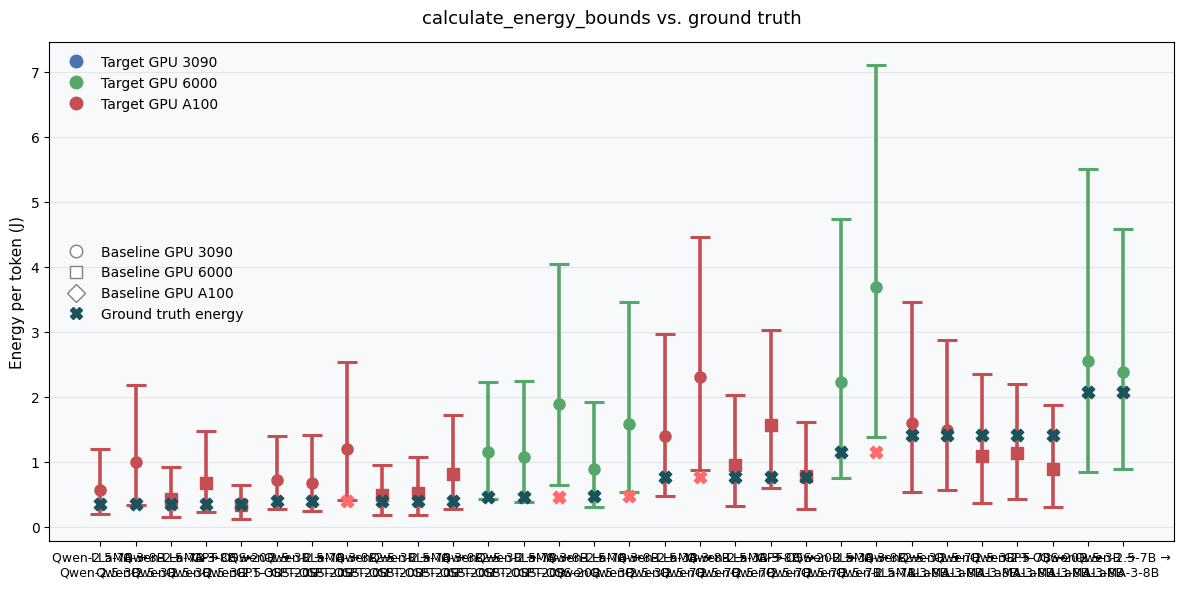

In [32]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Group comparisons by target entry and overlay bounds from all eligible baselines
grouped = {}
for target in data:
    grouped[(target['model'], target['gpu'])] = {
        'target': target,
        'comparisons': []
    }

for base, target in itertools.permutations(data, 2):
    if base['model'] == target['model'] or base['gpu'] == target['gpu']:
        continue
    lower, middle, upper = calculate_energy_bounds(
        E_baseline=base['energy_per_token_j'],
        N_target=target['params'],
        N_baseline=base['params'],
        G_target=1,
        G_baseline=1,
        B_target=target['bandwidth_gbs'],
        B_baseline=base['bandwidth_gbs'],
        P_target=target['power_w'],
        P_baseline=base['power_w']
    )
    grouped[(target['model'], target['gpu'])]['comparisons'].append({
        'base_model': base['model'],
        'base_gpu': base['gpu'],
        'lower': lower,
        'middle': middle,
        'upper': upper
    })

# Keep targets ordered by their true energy for readability
ordered = sorted(grouped.values(), key=lambda g: g['target']['energy_per_token_j'])

gpu_short = {'RTX 3090': '3090', 'RTX 6000': '6000', 'A100': 'A100'}
gpu_palette = {'RTX 3090': '#4C72B0', 'RTX 6000': '#55A868', 'A100': '#C44E52'}
model_markers = {'Qwen-2.5-3B': 'o', 'Qwen-2.5-7B': 's', 'LLaMA-3-8B': 'D', 'GPT-OSS-20B': '^'}

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#F7F9FB')
ax.grid(axis='y', alpha=0.25)

for x, entry in enumerate(ordered):
    comps = entry['comparisons']
    true_energy = entry['target']['energy_per_token_j']
    # Draw the ground-truth band slightly wider than jitter span
    ax.hlines(true_energy, x - 0.35, x + 0.35, colors='#1A535C', linestyles='-', linewidth=2.4)
    jitter_count = max(1, len(comps))
    for i, comp in enumerate(comps):
        # Center the jitter around x
        offset = (i - (jitter_count - 1)/2) * 0.07
        xp = x + offset
        color = gpu_palette.get(comp['base_gpu'], '#888')
        marker = model_markers.get(comp['base_model'], 'o')
        lower_err = comp['middle'] - comp['lower']
        upper_err = comp['upper'] - comp['middle']
        ax.errorbar(
            xp, comp['middle'],
            yerr=[[lower_err], [upper_err]],
            fmt=marker, color=color, ecolor=color,
            elinewidth=2, capsize=5, capthick=2, markersize=6, alpha=0.9
        )

ax.set_xticks(range(len(ordered)))
ax.set_xticklabels([f"{e['target']['model']}\nGPU {gpu_short[e['target']['gpu']]}" for e in ordered], fontsize=9)
ax.set_ylabel('Energy per token (J)', fontsize=11)
ax.set_title('Extrapolated bounds per target (overlapping all baselines)', fontsize=13, pad=14)

legend_colors = [Line2D([0],[0], marker='o', color=color, linestyle='', markersize=8, label=f"Baseline GPU {gpu_short[gpu]}") for gpu, color in gpu_palette.items()]
legend_markers = [Line2D([0],[0], marker=m, color='gray', linestyle='', markersize=8, markerfacecolor='white', label=model) for model, m in model_markers.items()]
truth_line = Line2D([0],[0], color='#1A535C', linewidth=2.4, label='Ground truth energy')
leg1 = ax.legend(handles=legend_colors, loc='upper left', frameon=False)
ax.add_artist(leg1)
leg2 = ax.legend(handles=legend_markers + [truth_line], loc='upper left', bbox_to_anchor=(0, 0.6), frameon=False)

fig.tight_layout()
plt.show()
